In [1]:
import tensorflow as tf               
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt       
import pandas as pd                   
import numpy as np                    
import os
import time

## 3,4,5,6,7일 단위로 실험해봤을때, 7일단위로 끊는게 정확도가 제일 높았음.(그다음으론 3일단위-논문에선 3일이용)
train set: 2016.01.01~2017.02.28  

validation set : 2017.03.01~2017.04.30  

test set : 2017.05.01~2017.09.20  

    



## 7일씩 24시간 saver

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


[step: 0] loss2: 4596.7958984375
overfitting warning2: 1
overfitting warning2: 2
overfitting warning2: 1
overfitting warning2: 2
overfitting warning2: 3
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 2
overfitting warning2: 3
overfitting warning2: 1
[step: 300] loss2: 36.107696533203125
overfitting warning2: 1
[step: 600] loss2: 32.94149398803711
overfitting warning2: 1
[step: 900] loss2: 31.763538360595703
overfitting warning2: 1
[step: 1200] loss2: 29.484079360961914
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
[step: 1500] loss2: 29.86587905883789
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
[step: 1800] loss2: 28.56332015991211
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
overfitting warning2: 1
[step: 2100] loss2:

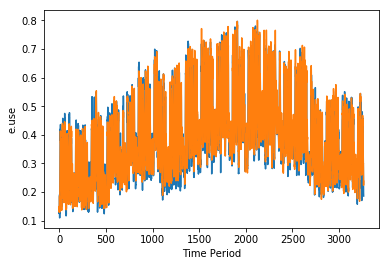

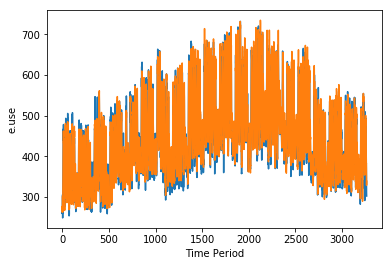

MAPE2: 4.988823120862046
MAPE3: 8.841508174619083
start_time 1534835193.6320086
----31296.672034740448 seconds---


In [2]:
tf.reset_default_graph()
tf.set_random_seed(777)

def MinMaxScaler(data):
    Max = np.max(data, 0)
    Min = np.min(data, 0)
    numerator = data - Min
    denominator = Max - Min
    return (Min, Max, (numerator / (denominator + 1e-7)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# train Parameters 
seq_length2 =168 #확정
data_dim2 = 2
hidden_dim2 = 8 #확정
output_dim2 = 1
learning_rate2 = 0.02 #확정
iterations2 = 6000
num_cell_layer2 = 2 #확정
#batch_size = 100

forget_bias = 1.0     # 망각편향(기본값 1.0)
keep_prob = 0.93   # dropout할 때 keep할 비율

earlystop_threshold2 = 100
earlystop_cnt2 = 0

# 전력사용량,
xy2 = np.loadtxt('final_hour.csv', delimiter=',')
# xy = xy[::-1]  # reverse order (chronically ordered)
Min2, Max2, xy2 = MinMaxScaler(xy2)
x2 = xy2
y2 = xy2[:, [0]]  # Close as label


# build a dataset
dataX2 = []
dataY2 = []
for i in range(0, len(y2) - seq_length2):
    _x2 = x2[i:i + seq_length2]
    _y2 = y2[i + seq_length2]  # Next e.use

    dataX2.append(_x2)
    dataY2.append(_y2)

# train/test split
train_size2 = 10200 
val_size2 = 1464
test_size2= 3432


trainX2, valX2, testX2 = np.array(dataX2[0:train_size2]), np.array(dataX2[train_size2:train_size2+val_size2]),np.array(dataX2[train_size2+val_size2:len(dataX2)])
trainY2, valY2, testY2 = np.array(dataY2[0:train_size2]), np.array(dataY2[train_size2:train_size2+val_size2]),np.array(dataY2[train_size2+val_size2:len(dataY2)])



# input place holders
X2 = tf.placeholder(tf.float32, [None, seq_length2, data_dim2],name="X2")
Y2 = tf.placeholder(tf.float32, [None, 1],name="Y2")

# 모델(LSTM 네트워크) 생성
def lstm_cell():
    cell2 = tf.contrib.rnn.LSTMCell(num_units=hidden_dim2, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.tanh)
    if keep_prob < 1.0 :
        cell2 = tf.contrib.rnn.DropoutWrapper(cell2, output_keep_prob=keep_prob)
    return cell2


# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_cell_layer2)]
cell2 = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_cell_layer2 > 1 else lstm_cell()
    
outputs2, _states2 = tf.nn.dynamic_rnn(cell2, X2, dtype=tf.float32)
Y_pred2 = tf.contrib.layers.fully_connected(
    outputs2[:, -1], output_dim2, activation_fn=None) # We use the last cell's output

    
    
saver=tf.train.Saver()


# cost/loss
loss2 = tf.reduce_sum(tf.square(Y_pred2 - Y2))  # sum of the squares
# optimizer
optimizer2 = tf.train.AdamOptimizer(learning_rate2)
train2 = optimizer2.minimize(loss2)

# RMSE
targets2 = tf.placeholder(tf.float32, [None, 1],name="targets2")
predictions2 = tf.placeholder(tf.float32, [None, 1],name="predictions2")
rmse2 = tf.sqrt(tf.reduce_mean(tf.square(targets2 - predictions2)),name="rmse2")


sess=tf.Session()
init= tf.global_variables_initializer()
sess.run(init)



start=time.time()


# Training step
for i in range(iterations2):
    _2, step_loss2 = sess.run([train2, loss2], feed_dict={
                            X2: trainX2, Y2: trainY2})
    test_predict_train2 = sess.run(Y_pred2, feed_dict={X2: trainX2})
    MAPE_train2 = mean_absolute_percentage_error(trainY2, test_predict_train2)
    rmse_val_train2 = sess.run(rmse2, feed_dict={
                targets2: trainY2, predictions2: test_predict_train2})
    
    
    _val_2, step_loss_val_2 = sess.run([train2, loss2], feed_dict={
                            X2: valX2, Y2: valY2})
    test_predict_val2 = sess.run(Y_pred2, feed_dict={X2: valX2})
    MAPE_val2 = mean_absolute_percentage_error(valY2, test_predict_val2)
    rmse_val_val2 = sess.run(rmse2, feed_dict={
                targets2: valY2, predictions2: test_predict_val2})
    
    #print("RMSE2: {}".format(rmse_val2))
    if (i) % (iterations2/20) == 0:
        print("[step: {}] loss2: {}".format(i, step_loss2))
    
    
            
    
    # overfittong 확인
    if earlystop_cnt2 == earlystop_threshold2: 
        earlystop_cnt2 = 0
        # Save the variables to file.
        save_path = saver.save(sess, "./save_final_hour2/model2")
        print("RMSE_trian2: {}".format(rmse_val_train2))
        print("RMSE_val2: {}".format(rmse_val_val2))
        print("MAPE_trian2: {}".format(MAPE_train2))
        print("MAPE_val2: {}".format(MAPE_val2))
        break
    else:
        if rmse_val_train2 < rmse_val_val2:
            if earlystop_cnt2 == earlystop_threshold2:
                print("early stopped on "+str(i))
                break
            else:
                    earlystop_cnt2 = earlystop_cnt2 +1
                    print("overfitting warning2: "+str(earlystop_cnt2))
        else:
                earlystop_cnt2 = 0
        
        
    
        
        
        
        
save_path = saver.save(sess, "./save_final_hour2/model2")        
        
        
        
        
        
# Test step
keep_prob = 1.0
test_predict2 = sess.run(Y_pred2, feed_dict={X2: testX2})
rmse_val2 = sess.run(rmse2, feed_dict={
                targets2: testY2, predictions2: test_predict2})
print("RMSE2: {}".format(rmse_val2))

# Plot predictions
plt.plot(testY2)
plt.plot(test_predict2)
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

    
    
    
    




    
# MinMaxScaler 값 복귀
testY_t2=(testY2 * (Max2[0] - Min2[0]+ 1e-7)) + Min2[0]
test_predict_t2=(test_predict2 * (Max2[0] - Min2[0] + 1e-7)) + Min2[0]

# Plot predictions
plt.plot(testY_t2)
plt.plot(test_predict_t2)
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()


MAPE2 = mean_absolute_percentage_error(testY_t2, test_predict_t2)
print("MAPE2: {}".format(MAPE2))


MAPE3 = mean_absolute_percentage_error(testY2, test_predict2)
print("MAPE3: {}".format(MAPE3))
    
print("start_time",start)
print("----%s seconds---" %(time.time() - start))
sess.close()
    
    




## Restore 후,  2017년 9월 21일의 전력수요 예측 모델 구현(예측값으로 예측)

In [277]:
tf.reset_default_graph()
tf.set_random_seed(777)

def MinMaxScaler(data):
    Max = np.max(data, 0)
    Min = np.min(data, 0)
    numerator = data - Min
    denominator = Max - Min
    return (Min, Max, (numerator / (denominator + 1e-7)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# train Parameters 
seq_length2 =168 #확정
data_dim2 = 2
hidden_dim2 = 8 #확정
output_dim2 = 1
learning_rate2 = 0.02 #확정
iterations2 = 6000
num_cell_layer2 = 2 #확정
#batch_size = 100

forget_bias = 1.0     # 망각편향(기본값 1.0)
keep_prob = 0.93   # dropout할 때 keep할 비율

earlystop_threshold2 = 100
earlystop_cnt2 = 0



xy2 = np.loadtxt('final_hour.csv', delimiter=',')
############## 9.21 기온추가
predict_temperature = np.loadtxt('predict_temperature_9.21.csv', delimiter=',')
predict_temperature = np.array(predict_temperature).reshape(24,1)
x3=xy2[:,[1]]
x3=np.r_[x3,predict_temperature]
_,_,x3=MinMaxScaler(x3)
##############
Min2, Max2, xy2 = MinMaxScaler(xy2)
x2 = xy2
y2 = xy2[:, [0]]  # Close as label
predict_temperature=x3[-24:]




day_total=np.zeros(shape = (24,)).reshape(24,1)
day_total_max=np.zeros(shape = (24,)).reshape(24,1)


# 100번의 평균값.
for j in range(101):
    recent_data2 = np.array([xy2[len(xy2)-seq_length2 : ]])
    h2=[]
    day_predict2=[]

    for i in range(24):
        tf.reset_default_graph()
        tf.set_random_seed(777)


        # input place holders
        X2 = tf.placeholder(tf.float32, [None, seq_length2, data_dim2],name="X2")
        Y2 = tf.placeholder(tf.float32, [None, 1],name="Y2")

        # 모델(LSTM 네트워크) 생성
        def lstm_cell():
            cell2 = tf.contrib.rnn.LSTMCell(num_units=hidden_dim2, 
                                                forget_bias=forget_bias, state_is_tuple=True, activation=tf.tanh)
            if keep_prob < 1.0 :
                cell2 = tf.contrib.rnn.DropoutWrapper(cell2, output_keep_prob=keep_prob)
            return cell2


        # num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
        stackedRNNs = [lstm_cell() for _ in range(num_cell_layer2)]
        cell2 = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_cell_layer2 > 1 else lstm_cell()

        outputs2, _states2 = tf.nn.dynamic_rnn(cell2, X2, dtype=tf.float32)
        Y_pred2 = tf.contrib.layers.fully_connected(
            outputs2[:, -1], output_dim2, activation_fn=None) # We use the last cell's output

        sess=tf.Session()
        saver=tf.train.Saver()
        saver.restore(sess,"./save_final_hour2/model2")
        test_predict_xy2 = sess.run(Y_pred2, feed_dict={X2: recent_data2})
        print("test_predict2", test_predict_xy2)

        
        
        # 24시간 전력수요량 저장.
        day_predict2.append(test_predict_xy2)
        sess.close()

        ##############################################################################

        # recent_Data update
        h2.append(test_predict_xy2) #예측전력
        h2.append(predict_temperature[i])  #기온9.21
        h2=np.array(h2)
        h2=h2.reshape(1,-1,2)
        recent_data2 = recent_data2[:,1:,:]
        recent_data2=np.r_[recent_data2[0],h2[0]].reshape(1,-1,2)
        h2=[]
    
    
    day_predict3=np.array(day_predict2)
    day_predict3=day_predict3.reshape(-1,1)
    day_total=day_total+day_predict3
    
    
    # 9시~16시까지는 제일 큰값 삽입(피크 시간 구할 용도)
    for k in range(8,16):
        if day_total_max[k]<=day_predict3[k]:
            day_total_max[k]=day_predict3[k]
   
    
    
    print("#######")
    print(j)
    print("#######")
    
    
day_total=day_total/101.0



# max값 update
for a in range(24):
    if day_total[a]<=day_total_max[a]:
        day_total[a] = day_total_max[a]



   

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17223698]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15026891]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1543788]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1491923]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15217742]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1637995]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1767354]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21621348]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2916451]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36203113]]
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17223698]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15123492]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2071842]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16230983]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17458254]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18873921]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19503605]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2583205]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3290053]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41499507]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1722312]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15026948]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17681536]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.14529881]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16688338]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1731635]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17924973]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22743735]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3037398]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38970312]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.39680246]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39548522]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35507184]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35003027]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33998203]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3061925]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26326805]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26815543]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23829176]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20711717]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1840561]]
INF

test_predict2 [[0.16768757]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15069836]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1615372]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.14606577]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15271753]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17282665]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17658481]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21832226]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2995069]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3629122]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43003628]]
INFO

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3633635]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31103954]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24880594]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24354634]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26763922]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24476604]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24119654]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2245286]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19642846]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2007584]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16036993]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15307862]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.14833483]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15654981]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1762543]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1802023]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22400908]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2988549]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.384335]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41898328]]
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16352153]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15646401]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15082636]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15902397]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15559334]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17951685]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22075751]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2969578]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3868924]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4178509]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15026528]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15443707]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.14918482]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15228665]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16387993]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17693812]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22212875]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29571438]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38576078]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4389836]]
INFO:tensorflow:Restoring param

test_predict2 [[0.3872033]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32322007]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34707725]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33594775]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35227764]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2854601]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25620976]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25643167]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22418773]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20149244]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17976335]]
###

test_predict2 [[0.15026897]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16334438]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15067622]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15332681]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16802555]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17909005]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22763082]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3021174]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3904973]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43874952]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41074604]]
INF

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34065425]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27892923]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27774388]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32271472]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30892044]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28439906]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26718658]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24323744]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22420752]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20423996]]
#######
52
#######
INFO:tensor

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15514436]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15355176]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15280658]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1660536]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17920911]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21882594]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29371363]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37226054]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4266175]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4251964]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.33746362]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28248456]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27741486]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3207025]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3097412]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28024453]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26341167]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23946825]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21067381]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19500306]]
#######
59
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2

test_predict2 [[0.33865362]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27050915]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25674874]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2529055]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26970196]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23387265]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21646821]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21222746]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18127257]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18145135]]
#######
66
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict

test_predict2 [[0.34347916]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2924617]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25907615]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30867445]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3159144]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28136367]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26516938]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23976797]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22589129]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20553543]]
#######
73
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2

test_predict2 [[0.16098791]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.14936522]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1618031]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.16673222]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18014485]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2231068]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29980126]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37886423]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43181148]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4263533]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41127893]]
INFO

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34625673]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32551935]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31065825]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30384332]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27742794]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2467527]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21906865]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19955325]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18816215]]
#######
80
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17307317]]
INFO:tensorf

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15459928]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15397614]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1664736]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18003386]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22526683]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29926455]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38719353]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4218961]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42168373]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41107613]]
INFO:tensorflow:Restoring parame

test_predict2 [[0.28790474]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29023778]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3340764]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3090767]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28784353]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2511949]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23161036]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23232011]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19298996]]
#######
87
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17223698]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 

test_predict2 [[0.15625682]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18288131]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17401543]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20784764]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24873492]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32918322]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41508046]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44776762]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42173564]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42836097]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41489142]]
I

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24912994]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29594186]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29970738]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28405324]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23549919]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22736299]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21448909]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18063158]]
#######
94
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17223698]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15043128]]
INFO:tensor

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.15360734]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1684519]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19059339]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2290791]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30260736]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39084697]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43844238]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42565462]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42852774]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4261075]]
INFO:tensorflow:Restoring paramet

In [282]:
day_total=np.array(day_total)
day_total=day_total.reshape(-1,1)
# MinMaxScaler 값 복귀
day_total_t2=(day_total * (Max2[0] - Min2[0] + 1e-7)) + Min2[0]
day_total_t2

array([[295.15845929],
       [281.9624633 ],
       [283.30780002],
       [279.37072291],
       [283.09281609],
       [290.75717436],
       [301.47298839],
       [331.1386302 ],
       [403.23815485],
       [464.68851124],
       [489.94753567],
       [477.42449675],
       [492.26166442],
       [475.85783174],
       [437.65268679],
       [424.24149965],
       [367.3337544 ],
       [387.98235045],
       [381.76877046],
       [364.64247818],
       [348.91284145],
       [335.038115  ],
       [319.669709  ],
       [305.34405874]])

## 2017.06.01~2017.09.20 전력수요그래프

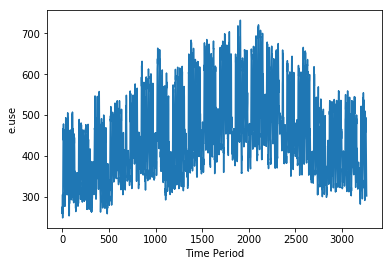

In [38]:
# Plot predictions
plt.plot(testY_t2)
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()


## 2017.06.01~2017.09.20 전력수요예측그래프

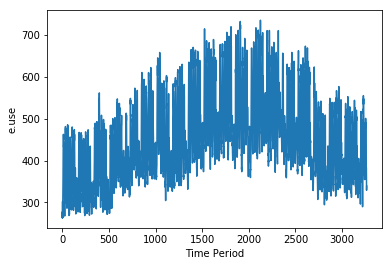

In [39]:
# Plot predictions
plt.plot(test_predict_t2)
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()


## 2016년 9~12월 전력수요,수요예측 그래프

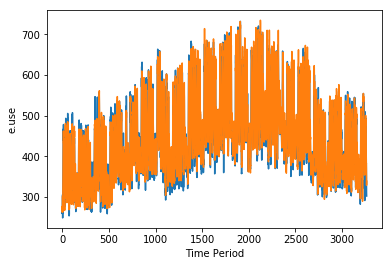

In [40]:
# Plot predictions
plt.plot(testY_t2)
plt.plot(test_predict_t2)
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()


MAPE=4.98

## 2017.9.20 전력수요그래프

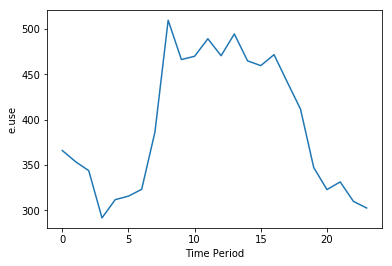

In [10]:
# Plot predictions
plt.plot(testY_t2[-24:,:])

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## Peak값이 주로 9~14시에서 나타남.

#testY_t2[-24:,:] #10~15
#testY_t2[-48:-24,:] #10~14
#testY_t2[-72:-48,:] #9~14
#testY_t2[-144:-120,:] #10~16
#testY_t2[-168:-144,:] #9~16
#testY_t2[-192:-168,:] #9~14
#testY_t2[-216:-192,:] #9~14

## 2017.9.20 전력수요예측 그래프

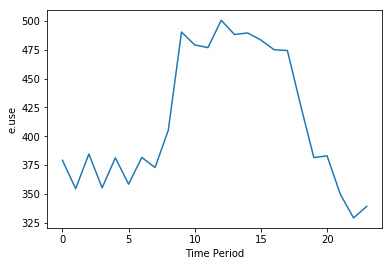

In [11]:
# Plot predictions

plt.plot(test_predict_t2[-24:,:])
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## 9.20 peak값의 차이

In [249]:
print("실제값 : ",max(testY_t2[-24:,:]),",\t예측값 : ",max(test_predict_t2[-24:,:]))
print("차이 : ",abs(max(testY_t2[-24:,:])-max(test_predict_t2[-24:,:])))

실제값 :  [509.52] ,	예측값 :  [500.609]
차이 :  [8.91099121]


## 9.20 총전력수요 차이


In [250]:
print("실제값 : ",testY_t2[-24:,:].sum(0),",\t예측값 : ",test_predict_t2[-24:,:].sum(0))
print("차이 : ", abs(testY_t2[-24:,:].sum(0)-test_predict_t2[-24:,:].sum(0)))

실제값 :  [9453.36] ,	예측값 :  [9939.189]
차이 :  [485.82945312]


## 2017.9.19 전력수요그래프

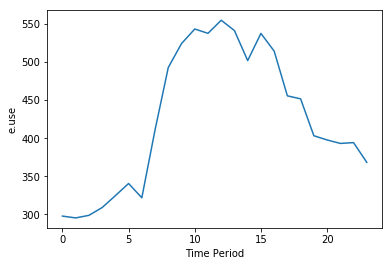

In [12]:
# Plot predictions
plt.plot(testY_t2[-48:-24,:])

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## 2017.9.19 전력수요예측그래프

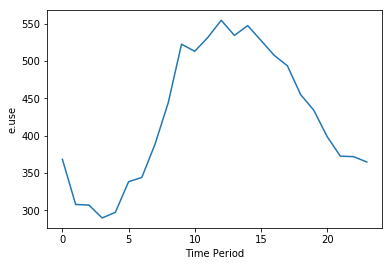

In [13]:
# Plot predictions

plt.plot(test_predict_t2[-48:-24,:])
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## 9.19 peak값의 차이

In [251]:
print("실제값 : ",max(testY_t2[-42:-24,:]),",\t예측값 : ",max(test_predict_t2[-42:-24,:]))
print("차이 : ",abs(max(testY_t2[-42:-24,:])-max(test_predict_t2[-42:-24,:])))


실제값 :  [554.64] ,	예측값 :  [554.74634]
차이 :  [0.10633789]


## 9.19 총전력수요 차이

In [252]:
print("실제값 ㅣ ",testY_t2[-42:-24,:].sum(0),",\t예측값 : ",test_predict_t2[-42:-24,:].sum(0))
print("차이 : ", abs(testY_t2[-42:-24,:].sum(0)-test_predict_t2[-42:-24,:].sum(0)))

실제값 ㅣ  [8342.64] ,	예측값 :  [8307.696]
차이 :  [34.94371094]


## 2017.9.18 전력수요그래프

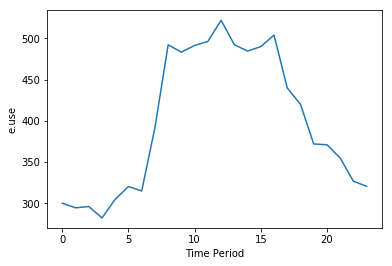

In [14]:
# Plot predictions
plt.plot(testY_t2[-72:-48,:])

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## 2017.9.18 전력수요예측그래프

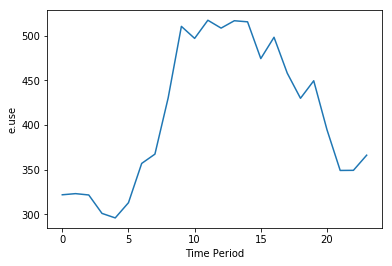

In [15]:
# Plot predictions

plt.plot(test_predict_t2[-72:-48,:])
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## 9.18 peak값의 차이

In [253]:
print("실제값 : ",max(testY_t2[-72:-48,:]),",\t예측값 : ",max(test_predict_t2[-72:-48,:]))
print("차이 : ",abs(max(testY_t2[-72:-48,:])-max(test_predict_t2[-72:-48,:])))


실제값 :  [521.76] ,	예측값 :  [517.05817]
차이 :  [4.7018335]


## 9.18 총전력수요 차이

In [254]:

print("실제값 : ",testY_t2[-72:-48,:].sum(0),",\t예측값 : ",test_predict_t2[-72:-48,:].sum(0))
print("차이 : ", abs(testY_t2[-72:-48,:].sum(0)-test_predict_t2[-72:-48,:].sum(0)))

실제값 :  [9565.92] ,	예측값 :  [9864.445]
차이 :  [298.5253125]


## 2017.9.17 전력수요그래프(일요일)

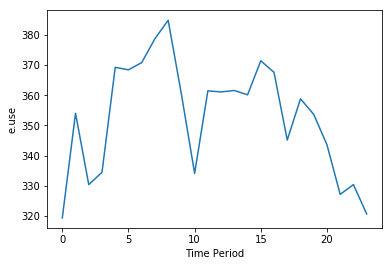

In [16]:
# Plot predictions
plt.plot(testY_t2[-96:-72,:])

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    


## 2017.9.17 전력수요예측그래프(일요일)

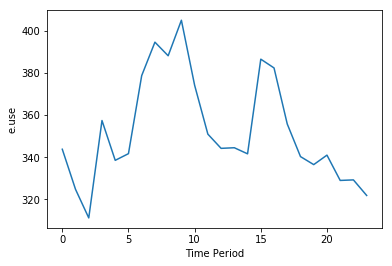

In [17]:
# Plot predictions

plt.plot(test_predict_t2[-96:-72,:])
plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()

## 9.17 peak값 차이

In [255]:
print("실제값 : ",max(testY_t2[-96:-72,:]),",\t예측값 : ",max(test_predict_t2[-96:-72,:]))
print("차이 : ",abs(max(testY_t2[-96:-72,:])-max(test_predict_t2[-96:-72,:])))


실제값 :  [384.84] ,	예측값 :  [405.0125]
차이 :  [20.17251221]


## 9.17 총전력수요 차이

In [256]:

print("실제값 : ",testY_t2[-96:-72,:].sum(0),",\t예측값 : ",test_predict_t2[-96:-72,:].sum(0))
print("차이 : ", abs(testY_t2[-96:-72,:].sum(0)-test_predict_t2[-96:-72,:].sum(0)))

실제값 :  [8466.96] ,	예측값 :  [8461.418]
차이 :  [5.54203125]


In [109]:
testY_t2[:744,:].sum(0),test_predict_t2[:744,:].sum(0)

testY_t2[744:1464,:].sum(0),test_predict_t2[744:1464,:].sum(0)

testY_t2[1464:2208,:].sum(0),test_predict_t2[1464:2208,:].sum(0)

testY_t2[2208:2952,:].sum(0),test_predict_t2[2208:2952,:].sum(0)

(array([282030.12]), array([282625.06], dtype=float32))

In [272]:
# 실제값 불러오기
true_value= np.loadtxt('true_9.21.csv', delimiter=',')
true_value=true_value.reshape(-1,1)
true_value

array([[286.56],
       [287.52],
       [299.52],
       [307.32],
       [293.88],
       [306.36],
       [340.92],
       [363.24],
       [528.72],
       [454.08],
       [465.48],
       [495.  ],
       [496.44],
       [498.  ],
       [449.16],
       [450.  ],
       [469.68],
       [413.76],
       [395.28],
       [343.32],
       [329.16],
       [318.96],
       [295.56],
       [306.24]])

## 2017.9.21 전력수요그래프

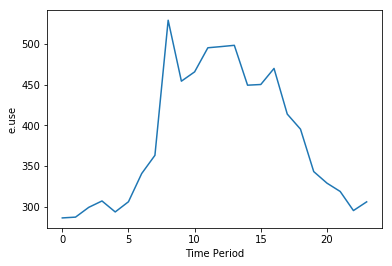

In [283]:
# Plot predictions
plt.plot(true_value)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## 2017.9.21 전력수요예측그래프(예측값으로 예측)

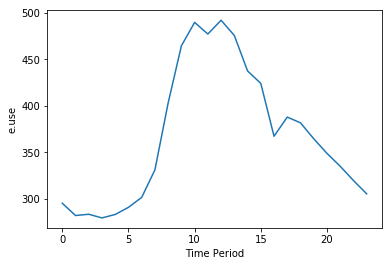

In [284]:
# Plot predictions
plt.plot(day_total_t2)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## Peak값 차이

In [285]:
print("실제값 : ",max(true_value),",\t예측값 : ",max(day_total_t2))
print("차이 : ",abs(max(true_value)-max(day_total_t2)))

실제값 :  [528.72] ,	예측값 :  [492.26166442]
차이 :  [36.45833558]


## 하루총량 차이

In [286]:
print("실제값 : ",true_value.sum(0),",\t예측값 : ",day_total_t2.sum(0))
print("차이 : ",abs(true_value.sum(0)-day_total_t2.sum(0)))

실제값 :  [9194.16] ,	예측값 :  [8822.26551335]
차이 :  [371.89448665]


## 9.20일의 전력수요량 예측모델(예측값으로 예측)

In [287]:
tf.reset_default_graph()
tf.set_random_seed(777)

def MinMaxScaler(data):
    Max = np.max(data, 0)
    Min = np.min(data, 0)
    numerator = data - Min
    denominator = Max - Min
    return (Min, Max, (numerator / (denominator + 1e-7)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# train Parameters 
seq_length2 =168 #확정
data_dim2 = 2
hidden_dim2 = 8 #확정
output_dim2 = 1
learning_rate2 = 0.02 #확정
iterations2 = 6000
num_cell_layer2 = 2 #확정
#batch_size = 100

forget_bias = 1.0     # 망각편향(기본값 1.0)
keep_prob = 0.93   # dropout할 때 keep할 비율

earlystop_threshold2 = 100
earlystop_cnt2 = 0



xy2 = np.loadtxt('final_hour.csv', delimiter=',')
############## 9.20 기온추가
predict_temperature = np.loadtxt('predict_temperature_9.20.csv', delimiter=',')
predict_temperature = np.array(predict_temperature).reshape(24,1)
x3=xy2[:,[1]]
x3=np.r_[x3,predict_temperature]
_,_,x3=MinMaxScaler(x3)
##############
Min2, Max2, xy2 = MinMaxScaler(xy2)
x2 = xy2
y2 = xy2[:, [0]]  # Close as label
predict_temperature=x3[-24:]




day_total=np.zeros(shape = (24,)).reshape(24,1)
day_total_max=np.zeros(shape = (24,)).reshape(24,1)


# 100번의 평균값.
for j in range(100):
    recent_data2 = np.array([xy2[len(xy2)-seq_length2-24 :-24 ]])
    h2=[]
    day_predict2=[]

    for i in range(24):
        tf.reset_default_graph()
        tf.set_random_seed(777)


        # input place holders
        X2 = tf.placeholder(tf.float32, [None, seq_length2, data_dim2],name="X2")
        Y2 = tf.placeholder(tf.float32, [None, 1],name="Y2")

        # 모델(LSTM 네트워크) 생성
        def lstm_cell():
            cell2 = tf.contrib.rnn.LSTMCell(num_units=hidden_dim2, 
                                                forget_bias=forget_bias, state_is_tuple=True, activation=tf.tanh)
            if keep_prob < 1.0 :
                cell2 = tf.contrib.rnn.DropoutWrapper(cell2, output_keep_prob=keep_prob)
            return cell2


        # num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
        stackedRNNs = [lstm_cell() for _ in range(num_cell_layer2)]
        cell2 = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_cell_layer2 > 1 else lstm_cell()

        outputs2, _states2 = tf.nn.dynamic_rnn(cell2, X2, dtype=tf.float32)
        Y_pred2 = tf.contrib.layers.fully_connected(
            outputs2[:, -1], output_dim2, activation_fn=None) # We use the last cell's output

        sess=tf.Session()
        saver=tf.train.Saver()
        saver.restore(sess,"./save_final_hour2/model2")
        test_predict_xy2 = sess.run(Y_pred2, feed_dict={X2: recent_data2})
        print("test_predict2", test_predict_xy2)

        
        
        # 24시간 전력수요량 저장.
        day_predict2.append(test_predict_xy2)
        sess.close()

        ##############################################################################

        # recent_Data update
        h2.append(test_predict_xy2) #예측전력
        h2.append(predict_temperature[i])  #기온9.21
        h2=np.array(h2)
        h2=h2.reshape(1,-1,2)
        recent_data2 = recent_data2[:,1:,:]
        recent_data2=np.r_[recent_data2[0],h2[0]].reshape(1,-1,2)
        h2=[]
    
    
    day_predict3=np.array(day_predict2)
    day_predict3=day_predict3.reshape(-1,1)
    day_total=day_total+day_predict3
    
    
    # 9시~14시까지는 제일 큰값 삽입(피크 시간 구할 용도)
    for k in range(8,14):
        if day_total_max[k]<=day_predict3[k]:
            day_total_max[k]=day_predict3[k]
   
    
    
    print("#######")
    print(j)
    print("#######")
    
    
day_total=day_total/100.0



# max값 update
for a in range(24):
    if day_total[a]<=day_total_max[a]:
        day_total[a] = day_total_max[a]



   

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26500383]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26599747]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26141047]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25525934]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27428705]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2915534]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32219777]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3826471]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4503427]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.48926964]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.48766983]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.48540145]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4624385]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44687638]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45516187]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4517509]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41210493]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37174714]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32839638]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29256466]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29323986]]
INF

test_predict2 [[0.26500383]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2659964]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26141053]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26538694]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27771455]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29129314]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3249134]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3836686]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45088595]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.48827395]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5025127]]
INFO:

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.47203138]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44429255]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43369302]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4500308]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41694647]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39917418]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35421112]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3317049]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28508067]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28686324]]
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26599747]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2663285]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2769605]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27330232]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2933588]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32547882]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3831416]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4504464]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4738541]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4696171]]
INFO:tensorflow:Restoring parameters 

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25375548]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25091296]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26499793]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26359493]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2844059]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31886265]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37718108]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4452116]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4806326]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49586797]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.4719774]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44303983]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.431032]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43675148]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4153055]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39766806]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36324495]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33156884]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31020805]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27359676]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2768129]]
######

test_predict2 [[0.2664469]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26137838]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26492417]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27789867]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29135454]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3248865]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40103596]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.445782]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.46285653]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.46370596]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49308747]]
INFO:

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43739972]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4236954]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4408123]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44657132]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40821868]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36872378]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34104162]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31735066]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2955693]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27726185]]
#######
31
#######
INFO:tensorflo

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26107275]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27041894]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2790477]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29263586]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32727194]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40332216]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4534936]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49118465]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5062331]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5034366]]
INFO:tensorflow:Restoring paramete

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2654204]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26198548]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2793483]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29667673]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32569277]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38744178]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4413198]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4809142]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49886894]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.50430113]]
INFO:tensorflow:Restoring paramete

test_predict2 [[0.2612233]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26500022]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2864497]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2983755]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3273673]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3881467]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44118637]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.48027763]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49923283]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5048428]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.47686064]]
INFO:te

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44219446]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4513863]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4263132]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4047529]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34158367]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30956358]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28278702]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28119385]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26027986]]
#######
52
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.257138]]
INFO:tensorflow:

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2562427]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28008327]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29313472]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32461244]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3856888]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.451823]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49029616]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.50266397]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49186438]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49061885]]
INFO:tensorflow:Restoring paramete

test_predict2 [[0.403597]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.433174]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4382815]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39709842]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3619759]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3326627]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3114314]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29242873]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26070198]]
#######
59
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25751328]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2

test_predict2 [[0.26579675]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27916566]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29234773]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3382697]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39252636]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45863348]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4962746]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5095467]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5159944]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.48554474]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4659881]]
INFO:t

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42447776]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43107897]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38248077]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32856637]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30036724]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29593927]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27119428]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24964045]]
#######
66
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26500383]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26599747]]
INFO:tensor

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27771905]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3008635]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3243702]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3859811]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45689428]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4945219]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.50698566]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49663186]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4941442]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4715613]]
INFO:tensorflow:Restoring parameters

test_predict2 [[0.40535393]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37502223]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36697742]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3420597]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30428866]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2662145]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26711237]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25865537]]
#######
73
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26500326]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26599747]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2

test_predict2 [[0.45488808]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42735916]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39636806]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36391544]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.334485]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2849254]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2651989]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2672724]]
#######
80
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26500383]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25121123]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2910752]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32469657]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3838421]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44055575]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44334224]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43845508]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.47434562]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4697599]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43029356]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39865783]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28509068]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33031887]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38519406]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45176947]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49070966]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.5033688]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.49142027]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4918359]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.46931797]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4415007]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.43086243]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3704045]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35005444]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.324558]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2965471]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27527726]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25813776]]
#######
94
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27118725]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26571274]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26212317]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [

test_predict2 [[0.2857839]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32235256]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3811228]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4278332]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.46892923]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.46170002]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4840744]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.47632787]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44753322]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41755563]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40432036]]
INFO:

In [288]:
# 실제값 불러오기
true_value = np.loadtxt('true_9.20.csv', delimiter=',')
true_value=true_value.reshape(-1,1)
true_value

array([[365.88],
       [353.64],
       [343.68],
       [291.6 ],
       [311.76],
       [315.6 ],
       [323.16],
       [386.16],
       [509.52],
       [466.2 ],
       [469.8 ],
       [489.12],
       [470.4 ],
       [494.4 ],
       [464.76],
       [459.48],
       [471.6 ],
       [441.36],
       [411.6 ],
       [347.16],
       [322.8 ],
       [331.32],
       [309.84],
       [302.52]])

In [289]:
day_total=np.array(day_total)
day_total=day_total.reshape(-1,1)
# MinMaxScaler 값 복귀
day_total_t2=(day_total * (Max2[0] - Min2[0] + 1e-7)) + Min2[0]
day_total_t2

array([[358.76858674],
       [358.50699646],
       [354.95097553],
       [358.3348446 ],
       [366.87047315],
       [376.99265769],
       [401.51642489],
       [443.50779677],
       [501.54123865],
       [526.18901467],
       [533.98702699],
       [534.76071826],
       [528.9277567 ],
       [516.43856179],
       [479.64833354],
       [472.62873806],
       [480.84194693],
       [474.12725576],
       [446.74173037],
       [420.64340849],
       [400.54176462],
       [383.38373613],
       [370.53142584],
       [358.88260811]])

## 9.20 전력수요그래프

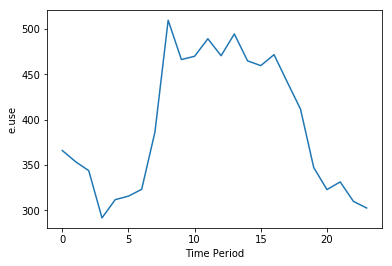

In [290]:
# Plot predictions
plt.plot(true_value)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## 9.20 전력수요예측 그래프(예측값으로 예측)

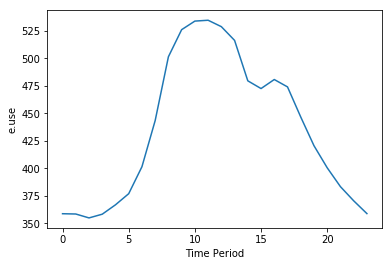

In [291]:
# Plot predictions
plt.plot(day_total_t2)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## Peak값 차이

In [292]:
print("실제값 : ",max(true_value),",\t예측값 : ",max(day_total_t2))
print("차이 : ",abs(max(true_value)-max(day_total_t2)))

실제값 :  [509.52] ,	예측값 :  [534.76071826]
차이 :  [25.24071826]


## 하루총량 차이 

In [293]:
print("실제값 : ",true_value.sum(0),",\t예측값 : ",day_total_t2.sum(0))
print("차이 : ",abs(true_value.sum(0)-day_total_t2.sum(0)))

실제값 :  [9453.36] ,	예측값 :  [10449.26402073]
차이 :  [995.90402073]


## 9.19일의 예측모델(예측값으로 예측)

In [294]:
tf.reset_default_graph()
tf.set_random_seed(777)

def MinMaxScaler(data):
    Max = np.max(data, 0)
    Min = np.min(data, 0)
    numerator = data - Min
    denominator = Max - Min
    return (Min, Max, (numerator / (denominator + 1e-7)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# train Parameters 
seq_length2 =168 #확정
data_dim2 = 2
hidden_dim2 = 8 #확정
output_dim2 = 1
learning_rate2 = 0.02 #확정
iterations2 = 6000
num_cell_layer2 = 2 #확정
#batch_size = 100

forget_bias = 1.0     # 망각편향(기본값 1.0)
keep_prob = 0.93   # dropout할 때 keep할 비율

earlystop_threshold2 = 100
earlystop_cnt2 = 0



xy2 = np.loadtxt('final_hour.csv', delimiter=',')
############## 9.20 기온추가
predict_temperature = np.loadtxt('predict_temperature_9.19.csv', delimiter=',')
predict_temperature = np.array(predict_temperature).reshape(24,1)
x3=xy2[:,[1]]
x3=np.r_[x3,predict_temperature]
_,_,x3=MinMaxScaler(x3)
##############
Min2, Max2, xy2 = MinMaxScaler(xy2)
x2 = xy2
y2 = xy2[:, [0]]  # Close as label
predict_temperature=x3[-24:]




day_total=np.zeros(shape = (24,)).reshape(24,1)
day_total_max=np.zeros(shape = (24,)).reshape(24,1)


# 200번의 평균값.
for j in range(100):
    recent_data2 = np.array([xy2[len(xy2)-seq_length2-48 :-48 ]])
    h2=[]
    day_predict2=[]

    for i in range(24):
        tf.reset_default_graph()
        tf.set_random_seed(777)


        # input place holders
        X2 = tf.placeholder(tf.float32, [None, seq_length2, data_dim2],name="X2")
        Y2 = tf.placeholder(tf.float32, [None, 1],name="Y2")

        # 모델(LSTM 네트워크) 생성
        def lstm_cell():
            cell2 = tf.contrib.rnn.LSTMCell(num_units=hidden_dim2, 
                                                forget_bias=forget_bias, state_is_tuple=True, activation=tf.tanh)
            if keep_prob < 1.0 :
                cell2 = tf.contrib.rnn.DropoutWrapper(cell2, output_keep_prob=keep_prob)
            return cell2


        # num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
        stackedRNNs = [lstm_cell() for _ in range(num_cell_layer2)]
        cell2 = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_cell_layer2 > 1 else lstm_cell()

        outputs2, _states2 = tf.nn.dynamic_rnn(cell2, X2, dtype=tf.float32)
        Y_pred2 = tf.contrib.layers.fully_connected(
            outputs2[:, -1], output_dim2, activation_fn=None) # We use the last cell's output

        sess=tf.Session()
        saver=tf.train.Saver()
        saver.restore(sess,"./save_final_hour2/model2")
        test_predict_xy2 = sess.run(Y_pred2, feed_dict={X2: recent_data2})
        print("test_predict2", test_predict_xy2)

        
        
        # 24시간 전력수요량 저장.
        day_predict2.append(test_predict_xy2)
        sess.close()

        ##############################################################################

        # recent_Data update
        h2.append(test_predict_xy2) #예측전력
        h2.append(predict_temperature[i])  #기온9.21
        h2=np.array(h2)
        h2=h2.reshape(1,-1,2)
        recent_data2 = recent_data2[:,1:,:]
        recent_data2=np.r_[recent_data2[0],h2[0]].reshape(1,-1,2)
        h2=[]
    
    
    day_predict3=np.array(day_predict2)
    day_predict3=day_predict3.reshape(-1,1)
    day_total=day_total+day_predict3
    
    
    # 9시~14시까지는 제일 큰값 삽입(피크 시간 구할 용도)
    for k in range(8,14):
        if day_total_max[k]<=day_predict3[k]:
            day_total_max[k]=day_predict3[k]
   
    
    
    print("#######")
    print(j)
    print("#######")
    
    
day_total=day_total/100.0



# max값 update
for a in range(24):
    if day_total[a]<=day_total_max[a]:
        day_total[a] = day_total_max[a]



   

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2122893]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19034614]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18793762]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19279058]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19486973]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20168146]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21830449]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26492235]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3378483]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40378124]]
INFO:tensorflow:Restoring parame

test_predict2 [[0.44202957]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44265863]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40286067]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36412033]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36037606]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32145393]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28528133]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29322374]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2644548]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23525926]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22037855]]
IN

test_predict2 [[0.21230891]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19278473]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18766528]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19301745]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19297814]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20170161]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22047617]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26586962]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33639115]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40279004]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43677035]]
I

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4102927]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37241855]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32467705]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33775726]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3654191]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32457548]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28988528]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27346742]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22280654]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22022632]]
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19293347]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18427214]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20138492]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1952984]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20100892]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22073457]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26632217]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.346565]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39329767]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40340742]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19290002]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20485617]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18227965]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19746733]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20888697]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2193695]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2651477]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33897147]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4039213]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41450223]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.41726184]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37778163]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33770543]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3749964]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37639356]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34019443]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29105294]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2830147]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24003592]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24029452]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21440768]]
###

test_predict2 [[0.19297126]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20512787]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19198753]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19731945]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21126252]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22317873]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27216002]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34589446]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39089596]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42422947]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44226012]]
I

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35070896]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31442174]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32948923]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32553238]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2995504]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2867677]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2625614]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23412487]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22231527]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1953159]]
#######
31
#######
INFO:tensorflow

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18784857]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24060445]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20121418]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20527498]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22984158]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27630493]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3381313]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39881438]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43288842]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4479942]]
INFO:tensorflow:Restoring parame

test_predict2 [[0.34814602]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36852098]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38330168]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38381636]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33482036]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29898512]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27684373]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24880423]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2318101]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2138287]]
#######
38
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2

test_predict2 [[0.1876843]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20037772]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19647542]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1994482]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22045343]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2673188]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3428115]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40968388]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4439544]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4510882]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.439645]]
INFO:tens

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32191145]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3257032]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3550645]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32977352]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2919413]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27037442]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24784838]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22023146]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21871524]]
#######
45
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2122893]]
INFO:tensorflow

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19359162]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19561337]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1997127]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21948878]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26500827]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33772975]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40405044]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4387103]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42989507]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42781147]]
INFO:tensorflow:Restoring parame

test_predict2 [[0.34052345]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34733424]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37513658]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34592506]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31007993]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28959173]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2685364]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24381204]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22506934]]
#######
52
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2122893]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3399638]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32745504]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3748868]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29767013]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27543658]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24290968]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22870082]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21229327]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18181664]]
#######
59
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21227694]]
INFO:tensorfl

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19153214]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20708762]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20200622]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2204548]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2670952]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34537813]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41037267]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42032677]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4391676]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43687272]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1929973]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19589385]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20053661]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21799819]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26101017]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32471538]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38910514]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42572874]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41673186]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41968805]]
INFO:tensorflow:Restoring param

test_predict2 [[0.32702947]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33172032]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34335938]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30620542]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27452916]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24733888]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22434562]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19708914]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18179959]]
#######
73
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21697614]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predic

test_predict2 [[0.361411]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37625042]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38433507]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34468165]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31079164]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2882141]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26543325]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24309021]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22291721]]
#######
80
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2122893]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [

test_predict2 [[0.19207768]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19559324]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20164284]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21805866]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.264927]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31959426]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3828917]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41956767]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4415718]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4256772]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41213998]]
INFO:t

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3609119]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38252932]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34630537]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3099446]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28839278]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26537263]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24127609]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22167012]]
#######
87
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20387043]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1931121]]
INFO:tensorflo

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19774207]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20473002]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22285971]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26669276]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34034878]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4053803]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4390811]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44771314]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44186357]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41740707]]
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19681808]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20346649]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21681896]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2643322]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33688644]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.402055]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43661925]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45022663]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4307235]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4102132]]
INFO:tensorflow:Restoring parameter

In [295]:
# 실제값 불러오기
true_value = np.loadtxt('true_9.19.csv', delimiter=',')
true_value=true_value.reshape(-1,1)
true_value

array([[297.84],
       [295.44],
       [298.8 ],
       [309.  ],
       [324.6 ],
       [340.56],
       [321.84],
       [410.88],
       [492.72],
       [524.04],
       [543.12],
       [537.48],
       [554.64],
       [541.08],
       [501.72],
       [537.36],
       [514.2 ],
       [455.52],
       [451.56],
       [403.2 ],
       [397.68],
       [393.12],
       [394.2 ],
       [368.28]])

In [296]:
day_total=np.array(day_total)
day_total=day_total.reshape(-1,1)
# MinMaxScaler 값 복귀
day_total_t2=(day_total * (Max2[0] - Min2[0] + 1e-7)) + Min2[0]
day_total_t2

array([[321.78994356],
       [309.01573624],
       [304.88379024],
       [308.52952613],
       [310.45018889],
       [315.84413604],
       [329.28305534],
       [362.58641385],
       [429.11413481],
       [477.02596413],
       [494.42638015],
       [492.15799222],
       [494.90527394],
       [491.92739975],
       [433.28068741],
       [409.00375613],
       [408.66363033],
       [418.25612192],
       [398.09811928],
       [374.12508989],
       [358.15918359],
       [342.7724682 ],
       [327.54634558],
       [314.76966962]])

## 9.19 전력수요 그래프

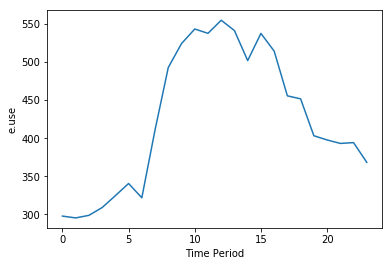

In [297]:
# Plot predictions
plt.plot(true_value)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## 9.19 전력수요예측 그래프(예측값으로 예측)

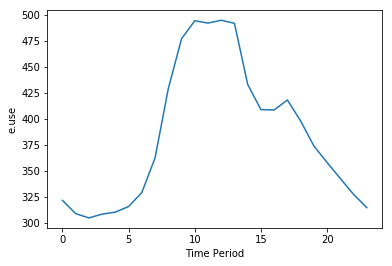

In [298]:
# Plot predictions
plt.plot(day_total_t2)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## Peak값 차이

In [299]:
print("실제값 : ",max(true_value),",\t예측값 : ",max(day_total_t2))
print("차이 : ",abs(max(true_value)-max(day_total_t2)))

실제값 :  [554.64] ,	예측값 :  [494.90527394]
차이 :  [59.73472606]


## 하루총량 차이

In [300]:
print("실제값 : ",true_value.sum(0),",\t예측값 : ",day_total_t2.sum(0))
print("차이 : ",abs(true_value.sum(0)-day_total_t2.sum(0)))

실제값 :  [10208.88] ,	예측값 :  [9226.61500725]
차이 :  [982.26499275]


## 9.18일의 전력수요예측 모델(예측값으로 예측)

In [301]:
tf.reset_default_graph()
tf.set_random_seed(777)

def MinMaxScaler(data):
    Max = np.max(data, 0)
    Min = np.min(data, 0)
    numerator = data - Min
    denominator = Max - Min
    return (Min, Max, (numerator / (denominator + 1e-7)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# train Parameters 
seq_length2 =168 #확정
data_dim2 = 2
hidden_dim2 = 8 #확정
output_dim2 = 1
learning_rate2 = 0.02 #확정
iterations2 = 6000
num_cell_layer2 = 2 #확정
#batch_size = 100

forget_bias = 1.0     # 망각편향(기본값 1.0)
keep_prob = 0.93   # dropout할 때 keep할 비율

earlystop_threshold2 = 100
earlystop_cnt2 = 0



xy2 = np.loadtxt('final_hour.csv', delimiter=',')
############## 9.20 기온추가
predict_temperature = np.loadtxt('predict_temperature_9.18.csv', delimiter=',')
predict_temperature = np.array(predict_temperature).reshape(24,1)
x3=xy2[:,[1]]
x3=np.r_[x3,predict_temperature]
_,_,x3=MinMaxScaler(x3)
##############
Min2, Max2, xy2 = MinMaxScaler(xy2)
x2 = xy2
y2 = xy2[:, [0]]  # Close as label
predict_temperature=x3[-24:]




day_total=np.zeros(shape = (24,)).reshape(24,1)
day_total_max=np.zeros(shape = (24,)).reshape(24,1)


# 100번의 평균값.
for j in range(100):
    recent_data2 = np.array([xy2[len(xy2)-seq_length2-72 :-72 ]])
    h2=[]
    day_predict2=[]

    for i in range(24):
        tf.reset_default_graph()
        tf.set_random_seed(777)


        # input place holders
        X2 = tf.placeholder(tf.float32, [None, seq_length2, data_dim2],name="X2")
        Y2 = tf.placeholder(tf.float32, [None, 1],name="Y2")

        # 모델(LSTM 네트워크) 생성
        def lstm_cell():
            cell2 = tf.contrib.rnn.LSTMCell(num_units=hidden_dim2, 
                                                forget_bias=forget_bias, state_is_tuple=True, activation=tf.tanh)
            if keep_prob < 1.0 :
                cell2 = tf.contrib.rnn.DropoutWrapper(cell2, output_keep_prob=keep_prob)
            return cell2


        # num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
        stackedRNNs = [lstm_cell() for _ in range(num_cell_layer2)]
        cell2 = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_cell_layer2 > 1 else lstm_cell()

        outputs2, _states2 = tf.nn.dynamic_rnn(cell2, X2, dtype=tf.float32)
        Y_pred2 = tf.contrib.layers.fully_connected(
            outputs2[:, -1], output_dim2, activation_fn=None) # We use the last cell's output

        sess=tf.Session()
        saver=tf.train.Saver()
        saver.restore(sess,"./save_final_hour2/model2")
        test_predict_xy2 = sess.run(Y_pred2, feed_dict={X2: recent_data2})
        print("test_predict2", test_predict_xy2)

        
        
        # 24시간 전력수요량 저장.
        day_predict2.append(test_predict_xy2)
        sess.close()

        ##############################################################################

        # recent_Data update
        h2.append(test_predict_xy2) #예측전력
        h2.append(predict_temperature[i])  #기온9.21
        h2=np.array(h2)
        h2=h2.reshape(1,-1,2)
        recent_data2 = recent_data2[:,1:,:]
        recent_data2=np.r_[recent_data2[0],h2[0]].reshape(1,-1,2)
        h2=[]
    
    
    day_predict3=np.array(day_predict2)
    day_predict3=day_predict3.reshape(-1,1)
    day_total=day_total+day_predict3
    
    
    # 9시~14시까지는 제일 큰값 삽입(피크 시간 구할 용도)
    for k in range(8,14):
        if day_total_max[k]<=day_predict3[k]:
            day_total_max[k]=day_predict3[k]
   
    
    
    print("#######")
    print(j)
    print("#######")
    
    
day_total=day_total/100.0



# max값 update
for a in range(24):
    if day_total[a]<=day_total_max[a]:
        day_total[a] = day_total_max[a]



   

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18805099]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18773794]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18379447]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18558908]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19290072]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20582747]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23332551]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28627285]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34001935]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37476844]]
INFO:tensorflow:Restoring para

test_predict2 [[0.4818656]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45854375]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41220462]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39087844]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41798416]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42072657]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3589042]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34463722]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3113402]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29563498]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.27395588]]
INFO

test_predict2 [[0.18805099]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20300213]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18578163]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18669692]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1992816]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21008524]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23954241]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29350162]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36321616]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42311248]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45634443]]
IN

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44117662]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40991756]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3936095]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41869393]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4129034]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.37181833]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33934793]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28302342]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2860002]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26481056]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22639567]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18795592]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20669024]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2095832]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21884651]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26109678]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3148021]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38348728]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4411535]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44476113]]
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19044343]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18588336]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18580626]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19708784]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20358674]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23759322]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2909854]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35933]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4205256]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45654258]]
INFO:tensorflow:Restoring parameter

test_predict2 [[0.4103694]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36240423]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3274948]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36052704]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3433505]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32782757]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.31365225]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28964207]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26820815]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24170221]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22097261]]
####

test_predict2 [[0.18810824]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18648799]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18973556]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20213604]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20979615]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23699293]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29173076]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35931405]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39361608]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43500453]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.455584]]
INF

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.38799727]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4170809]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43788776]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41454157]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36830792]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33692485]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30895108]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28321725]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25900632]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2379578]]
#######
31
#######
INFO:tensorfl

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18639931]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.17594081]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19206098]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21587057]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23367721]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28994715]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35952416]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41873163]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4378874]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40587592]]
INFO:tensorflow:Restoring param

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19073212]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18593417]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1861262]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20763966]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23263127]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.282054]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35265473]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4136532]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4526404]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4626575]]
INFO:tensorflow:Restoring parameters

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18583392]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19227402]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19320628]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20700245]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2444826]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29350883]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36256805]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39628616]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43550238]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4539358]]
INFO:tensorflow:Restoring parame

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18559626]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18179771]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19487976]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20540366]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23076707]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28459322]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3508283]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40996075]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4493866]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44822907]]
INFO:tensorflow:Restoring parame

test_predict2 [[0.37960294]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34563535]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36279207]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33446407]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32006255]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2670138]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25942674]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24851972]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21097997]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19689555]]
#######
59
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1855784]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.1927922]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21827346]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23711362]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28967753]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35949856]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41702318]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4303971]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45244825]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45103896]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.3873953]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41763622]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3798353]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36434287]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.34120464]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3124309]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2919966]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2694444]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24882093]]
#######
66
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18805099]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[

test_predict2 [[0.18579204]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19405283]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.215373]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23717186]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28964067]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35847947]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41673356]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4271679]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4503342]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44941422]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42057753]]
INFO:

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.39836413]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40592182]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36815828]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33307728]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2797177]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28131977]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2584668]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.22998586]]
#######
73
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18805099]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18716294]]
INFO:tensorfl

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.19448726]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20954669]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24061096]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2918153]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36043772]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4208291]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4558158]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.46532816]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45965323]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43535838]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.36541697]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.350263]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33335084]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28122157]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28022116]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26809958]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21960805]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21831737]]
#######
80
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18805099]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18773794]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2

test_predict2 [[0.19475752]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20863552]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23953685]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29186484]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35606286]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41563064]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40073252]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43364215]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4377752]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44275683]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40036184]]
IN

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3928529]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35497555]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.32797003]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2832224]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.26525867]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.25710386]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21845904]]
#######
87
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21732026]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18740582]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18785065]]
INFO:tensorfl

INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20661715]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.23774776]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.28928378]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33673406]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.3948497]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4351396]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.45513293]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.4474353]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41987568]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36798286]]
INFO:tensorflow:Restoring paramet

test_predict2 [[0.36416417]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.33348376]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.30193144]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.2626867]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.24426453]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.21592188]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.20215131]]
#######
94
#######
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18797255]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18827969]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.18579611]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict

test_predict2 [[0.21068658]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.245131]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.29688516]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36820814]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.42878255]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.40649754]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.43894243]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.44568163]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.41603753]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.36841512]]
INFO:tensorflow:Restoring parameters from ./save_final_hour2/model2
test_predict2 [[0.35901856]]
INF

In [302]:
# 실제값 불러오기
true_value = np.loadtxt('true_9.18.csv', delimiter=',')
true_value=true_value.reshape(-1,1)
true_value

array([[300.24],
       [294.72],
       [296.28],
       [282.48],
       [305.04],
       [320.52],
       [315.12],
       [391.68],
       [492.  ],
       [483.12],
       [491.28],
       [496.08],
       [521.76],
       [492.12],
       [484.44],
       [489.84],
       [503.76],
       [439.8 ],
       [420.  ],
       [372.  ],
       [371.04],
       [354.96],
       [326.88],
       [320.76]])

In [303]:
day_total=np.array(day_total)
day_total=day_total.reshape(-1,1)
# MinMaxScaler 값 복귀
day_total_t2=(day_total * (Max2[0] - Min2[0] + 1e-7)) + Min2[0]
day_total_t2

array([[306.35250055],
       [305.96187354],
       [303.29687537],
       [305.21331088],
       [309.5684085 ],
       [319.48710073],
       [339.76125326],
       [377.63206482],
       [441.47038759],
       [482.06970772],
       [498.65574833],
       [505.27341671],
       [510.73266739],
       [495.16534616],
       [436.70004569],
       [417.08481263],
       [428.20393259],
       [428.96723187],
       [407.33075987],
       [388.66483366],
       [373.24452657],
       [358.47078736],
       [341.39149896],
       [327.3703774 ]])

## 9.18 전력수요 그래프

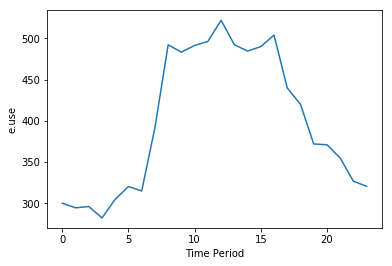

In [304]:
# Plot predictions
plt.plot(true_value)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## 9.18 전력수요예측 그래프(예측값으로 예측)

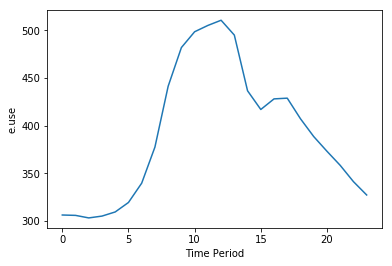

In [305]:
# Plot predictions
plt.plot(day_total_t2)

plt.xlabel("Time Period")
plt.ylabel("e.use")
plt.show()
    

## Peak값 차이

In [306]:
print("실제값 : ",max(true_value),",\t예측값 : ",max(day_total_t2))
print("차이 : ",abs(max(true_value)-max(day_total_t2)))

실제값 :  [521.76] ,	예측값 :  [510.73266739]
차이 :  [11.02733261]


## 하루총량 차이 

In [307]:
print("실제값 : ",true_value.sum(0),",\t예측값 : ",day_total_t2.sum(0))
print("차이 : ",abs(true_value.sum(0)-day_total_t2.sum(0)))

실제값 :  [9565.92] ,	예측값 :  [9408.06946813]
차이 :  [157.85053187]
